In [1]:

import kagglehub
deadskull7_fer2013_path = kagglehub.dataset_download('deadskull7/fer2013')
msambare_fer2013_path = kagglehub.dataset_download('msambare/fer2013')

print('Data source import complete.')


100%|██████████| 96.6M/96.6M [00:00<00:00, 230MB/s]

Extracting files...


100%|██████████| 60.3M/60.3M [00:00<00:00, 242MB/s]

Extracting files...


Data source import complete.


In [2]:
print("Deadskull7 FER2013 dataset path:", deadskull7_fer2013_path)
print("Msambare FER2013 dataset path:", msambare_fer2013_path)

Deadskull7 FER2013 dataset path: /root/.cache/kagglehub/datasets/deadskull7/fer2013/versions/1
Msambare FER2013 dataset path: /root/.cache/kagglehub/datasets/msambare/fer2013/versions/1


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [4]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPool2D, Bidirectional,AveragePooling2D, LSTM, Reshape ,Input, BatchNormalization, MaxPooling2D, Activation, Flatten, Dense, Dropout
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing import image
import scipy
import os
import cv2

In [5]:
data = pd.read_csv('/root/.cache/kagglehub/datasets/deadskull7/fer2013/versions/1/fer2013.csv')

In [6]:
data

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [7]:
x_data = data['pixels']
y_data = data['emotion']

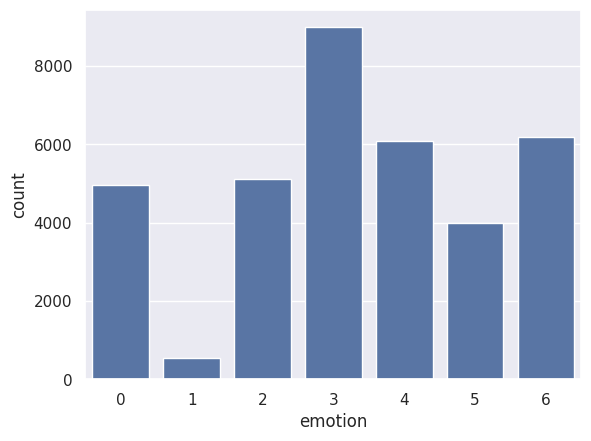

In [8]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="emotion", data=data)

In [9]:
oversampler = RandomOverSampler(sampling_strategy='auto')

x_data, y_data = oversampler.fit_resample(x_data.values.reshape(-1,1), y_data)
print(x_data.shape," ",y_data.shape)

(62923, 1)   (62923,)


In [10]:
y_data.value_counts()

,count
emotion,
0,8989
2,8989
4,8989
6,8989
3,8989
5,8989
1,8989


In [11]:
x_data = pd.Series(x_data.flatten())
x_data

,0
0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,151 150 147 155 148 133 111 140 170 174 182 15...
2,231 212 156 164 174 138 161 173 182 200 106 38...
3,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...
62918,255 255 255 253 243 137 41 39 38 27 24 35 38 3...
62919,105 176 161 190 164 248 239 248 253 255 254 25...
62920,203 191 128 78 49 1 8 7 5 6 10 13 30 57 84 109...
62921,214 214 216 217 218 184 95 53 51 42 49 43 48 8...


In [12]:
x_data = np.array(list(map(str.split, x_data)), np.float32)
x_data/=255
x_data[:10]

array([[0.27450982, 0.3137255 , 0.32156864, ..., 0.41568628, 0.42745098,
        0.32156864],
       [0.5921569 , 0.5882353 , 0.5764706 , ..., 0.75686276, 0.7176471 ,
        0.72156864],
       [0.90588236, 0.83137256, 0.6117647 , ..., 0.34509805, 0.43137255,
        0.59607846],
       ...,
       [0.3019608 , 0.30588236, 0.30980393, ..., 0.49019608, 0.2627451 ,
        0.26666668],
       [0.33333334, 0.32941177, 0.3529412 , ..., 0.22745098, 0.28627452,
        0.32941177],
       [1.        , 0.99607843, 1.        , ..., 0.99607843, 1.        ,
        1.        ]], dtype=float32)

In [13]:
x_data = x_data.reshape(-1, 48, 48, 1)
x_data.shape

(62923, 48, 48, 1)

In [14]:
y_data = np.array(y_data)
y_data = y_data.reshape(y_data.shape[0], 1)
y_data.shape

(62923, 1)

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.1, random_state = 45)

In [16]:
model = Sequential([
    Input((48, 48, 1)),
    Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Conv2D(64, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Conv2D(128, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Reshape((-1,128)),
    (LSTM(128)),
    (Reshape((-1,64))),
    LSTM(64),
#     (Reshape((-1,64)))
#     (LSTM(32))
    Dense(200, activation='relu'),
    Dropout(0.6),
    Dense(7, activation = 'softmax')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 46, 46, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 46, 46, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 46, 46, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 46, 46, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 46, 46, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 21, 21, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 21, 21, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 21, 21, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 21, 21, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 21, 21, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 21, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 16, 128)             │              

 Total params: 457,863 (1.75 MB)

 Trainable params: 457,031 (1.74 MB)

 Non-trainable params: 832 (3.25 KB)

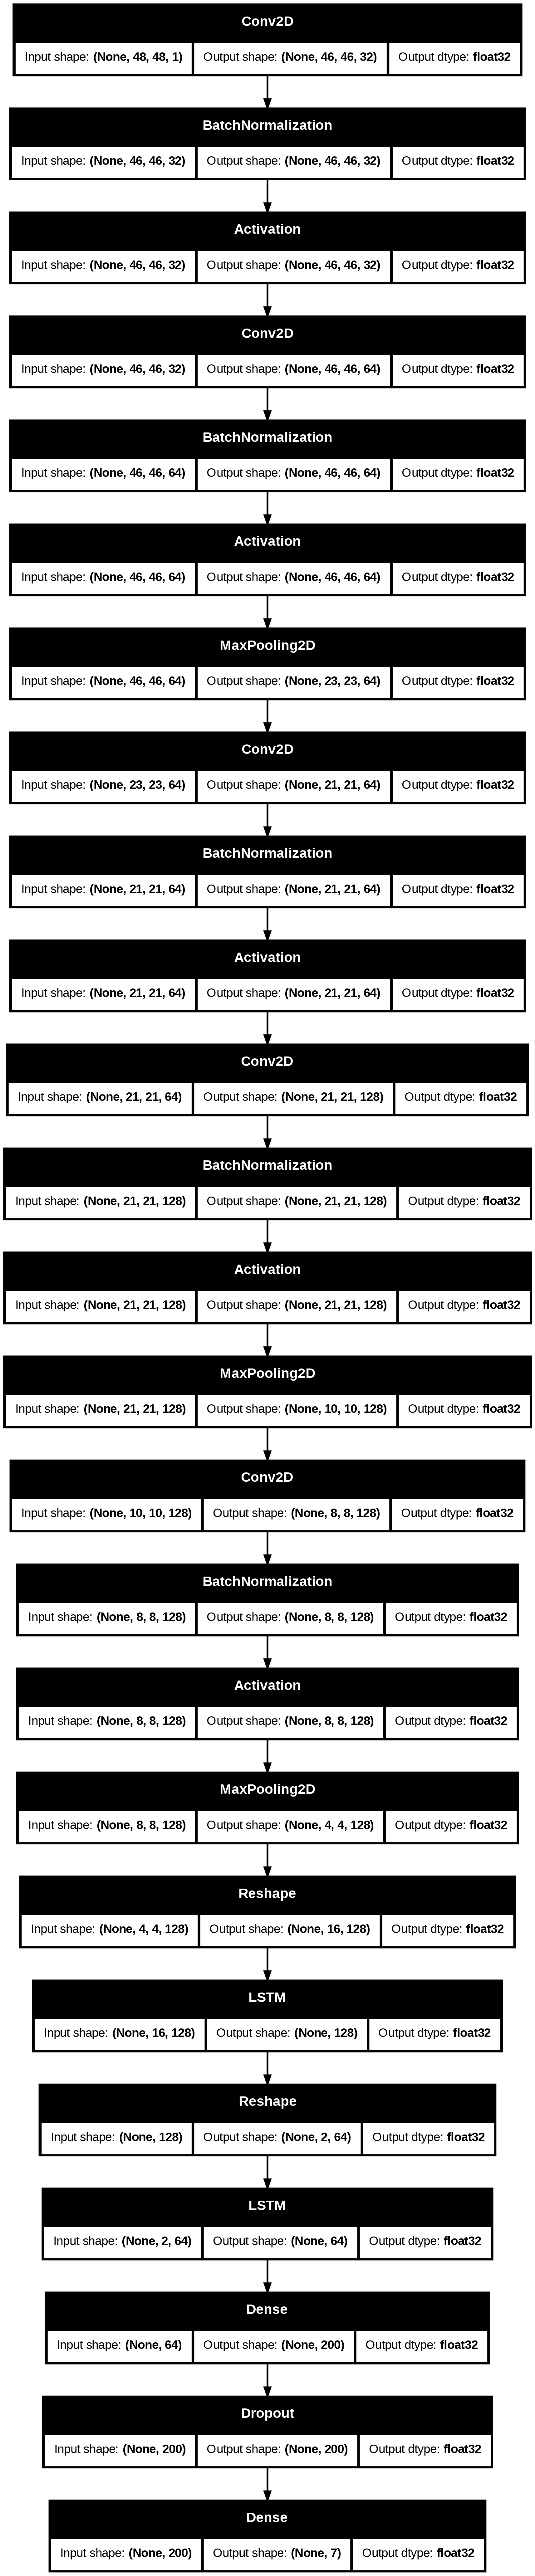

In [17]:
tf.keras.utils.plot_model(model, to_file = "model.png", show_shapes = True, show_dtype = True)

In [18]:
adam = keras.optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 7) # Use to_categorical directly from tensorflow.keras.utils
y_train.shape

(56630, 7)

In [20]:
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_test, 7)
y_test.shape

(6293, 7)

In [ ]:
history = model.fit(x_train, y_train, epochs = 25, validation_data=(x_test, y_test))

In [22]:
# Save the model to an HDF5 file
model.save("fer2013_bilstm_cnn.h5")
print("Model saved successfully as fer2013_bilstm_cnn.h5")

Model saved successfully as fer2013_bilstm_cnn.h5


In [23]:
print("Accuracy of our model on validation data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8107 - loss: 0.9420
Accuracy of our model on validation data :  81.02653622627258 %


In [24]:
y_pred = model.predict(x_test)
y_result = []

for pred in y_pred:
    y_result.append(np.argmax(pred))
y_result[:10]

197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


[6, 5, 5, 6, 1, 0, 2, 4, 1, 3]

In [25]:
y_actual = []

for pred in y_test:
    y_actual.append(np.argmax(pred))
y_actual[:10]

[6, 5, 5, 6, 1, 0, 3, 4, 1, 3]

In [26]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_actual, y_result))

              precision    recall  f1-score   support

           0       0.79      0.85      0.82       935
           1       0.99      1.00      0.99       895
           2       0.63      0.87      0.73       880
           3       0.87      0.77      0.82       906
           4       0.70      0.71      0.71       888
           5       0.96      0.82      0.88       869
           6       0.84      0.66      0.74       920

    accuracy                           0.81      6293
   macro avg       0.83      0.81      0.81      6293
weighted avg       0.83      0.81      0.81      6293



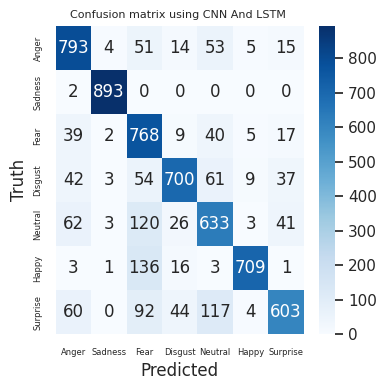

In [27]:
import seaborn as sn
cm = tf.math.confusion_matrix(labels = y_actual, predictions = y_result)

plt.figure(figsize = (4,4))
ax = plt.axes()
sn.heatmap(cm,cmap="Blues", annot = True, fmt = 'd')
ax.xaxis.set_ticklabels([  "Anger", "Sadness", "Fear", "Disgust", "Neutral","Happy","Surprise"], fontsize=6);
ax.yaxis.set_ticklabels([  "Anger", "Sadness", "Fear", "Disgust", "Neutral","Happy","Surprise"],  fontsize=6);

plt.title('Confusion matrix using CNN And LSTM ', fontsize = 8, fontweight=500)
plt.xlabel('Predicted')
plt.ylabel('Truth')


plt.savefig("confusion")

In [19]:
!pip install tensorflow

In [20]:
import coremltools as ct
import tensorflow as tf

In [21]:
keras_model = tf.keras.models.load_model('/Users/uvaishnav/Downloads/fer2013_bilstm_cnn.h5')

In [22]:
input_shape = (48, 48, 1)

In [23]:
# Define input and output descriptions
input_description = {'input_image': 'Grayscale face image for emotion detection'}
output_description = {'output': 'Probability of emotions (happy, sad, angry, etc.)'}

In [24]:
class_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

In [25]:
# Convert to Core ML format
coreml_model = ct.converters.keras.convert(
    keras_model,
    input_names=['image'],
    image_input_names=['image'],
    class_labels=class_labels,
    predicted_feature_name='emotion'
)

AttributeError: module 'coremltools.converters' has no attribute 'keras'

In [ ]:
# Save the Core ML model
coreml_model.save('EmotionClassifier.mlmodel')